# Bayesian sampler

gonna write this in python with pyro!

The Bayesian Sampler model is roughly:

$$P_{BS}(A) \sim Beta(\beta + S(A), \beta+F(A))$$

Where $S(A)$ and $F(A)$ are the number of success and failures sampled.

We can rewrite that:

$$P_{BS}(A) \sim Beta(\beta + \pi(A)N, \beta+(1-\pi(A))N)$$


Where $\pi(A)$ is the proportion of successes in the mental simulation with $N$ samples and is a function of the true underlying model probability, $p(A)$. It is distributed:

$$\pi(A) \sim Beta(p(A)*N, (1-p(A))*N)$$

To which we assign a uniform prior (or the multidimensional dirichlet equivalent):

$$p(A) \sim Beta(1,1)$$

In [912]:
%config IPCompleter.use_jedi = False
import torch as t
import pyro

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from pyro.infer import Importance, EmpiricalMarginal

import numpy as np
import pandas as pd
import seaborn as sns
import functools

t.set_default_tensor_type(t.DoubleTensor)

let's write down my thinking so far for the bayesian sampler and draw some samples!

In [840]:
def bsampler(query):
    beta = pyro.sample("beta", dist.HalfCauchy(1))
    N = pyro.sample("N", dist.HalfCauchy(5))
    theta = pyro.sample("theta", dist.Dirichlet(t.ones(4)))
    
    p = t.dot(theta, query)
    
    pi = pyro.sample("pi", dist.Beta(p*N, p*N))
    y_hat = pyro.sample("y_hat", dist.Beta(beta + pi*N, beta + (1-pi)*N))
    
    return y_hat

<AxesSubplot:ylabel='Count'>

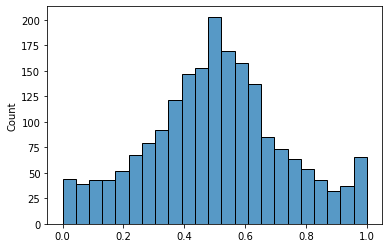

In [841]:
sns.histplot(np.array([bsampler(t.tensor([1.,1.,0.,0.])) for _ in range(2000)]))

Holy COW! that was a lot easier than writing in Stan!

Ok now let's pull in the data.

In [842]:
## starting with just one P b/c I am struggling w/ python rustiness and filepaths
from dfply import *
import glob
import pandas as pd

df_raw = pd.read_csv("osfstorage-archive/Experiment 2/PrEstExp_001_111218_115935.csv")

df = (df_raw >> 
      group_by(X.querytype) >> 
      summarize(estimate = X.estimate.mean()) >>
      mutate(estimate = X.estimate/100.)
     )

In [843]:
## data munging

conjdisj_trials = ["AorB","notAorB","AornotB","notAornotB", "AandB", "notAandB", "AandnotB", "notAandnotB"]

simple_df = df[~df.querytype.isin(conjdisj_trials)]
conjdisj_df = df[df.querytype.isin(conjdisj_trials)]

## design matrix stuff

# takes string expressing trial type and produces function
# function takes probabilities defining joint distribution
# returns probability of specified query

trial_funcs = dict({
    "AandB": lambda theta: t.dot(t.tensor([1.,0.,0.,0.]), theta) ,
    "AandnotB": lambda theta: t.dot(t.tensor([0.,1.,0.,0.]), theta),
    "notAandB": lambda theta: t.dot(t.tensor([0.,0.,1.,0.]), theta),
    "notAandnotB": lambda theta: t.dot(t.tensor([0.,0.,0.,1.]), theta),
    "A":lambda theta: t.dot(t.tensor([1.,1.,0.,0.]), theta),
    "B":lambda theta: t.dot(t.tensor([1.,0.,1.,0.]), theta),
    "notA":lambda theta: t.dot(t.tensor([0.,0.,1.,1.]), theta),
    "notB":lambda theta: t.dot(t.tensor([0.,1.,0.,1.]), theta),
    "AorB":lambda theta: t.dot(t.tensor([1.,1.,1.,0.]), theta),
    "AornotB":lambda theta: t.dot(t.tensor([1.,1.,0.,1.]), theta),
    "notAorB":lambda theta: t.dot(t.tensor([0.,1.,1.,1.]), theta),
    "notAornotB":lambda theta: t.dot(t.tensor([0.,1.,0.,1.]), theta),
    
    "AgB": lambda theta: t.div( t.dot(t.tensor([1.,0.,0.,0.]), theta), t.dot(t.tensor([1.,0.,1.,0.]), theta) ),
    "notAgB": lambda theta: t.div( t.dot(t.tensor([0.,0.,1.,0.]), theta), t.dot(t.tensor([1.,0.,1.,0.]), theta) ),
    "AgnotB": lambda theta: t.div( t.dot(t.tensor([0.,1.,0.,0.]), theta), t.dot(t.tensor([0.,1.,0.,1.]), theta) ),
    "notAgnotB": lambda theta: t.div( t.dot(t.tensor([0.,0.,0.,1.]), theta), t.dot(t.tensor([0.,1.,0.,1.]), theta) ),
    "BgA": lambda theta: t.div( t.dot(t.tensor([1.,0.,0.,0.]), theta), t.dot(t.tensor([1.,1.,0.,0.]), theta) ),
    "notBgA": lambda theta: t.div( t.dot(t.tensor([0.,1.,0.,0.]), theta), t.dot(t.tensor([1.,1.,0.,0.]), theta) ),
    "BgnotA": lambda theta: t.div( t.dot(t.tensor([0.,0.,1.,0.]), theta), t.dot(t.tensor([0.,0.,1.,1.]), theta) ),
    "notBgnotA": lambda theta: t.div( t.dot(t.tensor([0.,0.,0.,1.]), theta), t.dot(t.tensor([0.,0.,1.,1.]), theta) ),
})


def query_prob(trial, theta):
    f = trial_funcs[trial]
    return f(theta)

def dm_probs(trial_data, theta, n_obs):
    ## compute implied subj. probability from latent theta and trial type
    ## this is a vectorized solution: https://bit.ly/2P6mMcD
    p = t.tensor([])
    for i in range(0, n_obs):
        temp = trial_func[trial_data[i]](theta)
        p = t.cat( (p, t.tensor([temp])), 0)

    return p

# query_prob_vec = t.vmap(query_prob, n_dims = (None,0))

def dm_probs_vec(theta, trial_data):
    ## compute implied subj. probability from latent theta and trial type
    ## this is a vectorized solution: https://bit.ly/2P6mMcD
    
    ## going to try vectorizing using torch.vmap()
    
    query_prob(theta, trial_data)

    return p



## simulate data (for multiple blocks)

# trials = list(df["querytype"])




## the model (old)

# def bsampler(data):
#     n_obs = len(data["trials"])
        
#     # population level parameters/priors
#     beta = pyro.sample("beta", dist.HalfCauchy(.25))
#     N = pyro.sample("N", dist.HalfCauchy(5))
    
#     # need a theta per person/querytype (yes?)
#     theta = pyro.sample("theta", dist.Dirichlet(t.ones(4)))
#     p = dm_probs(data["trials"], theta, n_obs)
        
#     pi = pyro.sample("pi", dist.Beta(p*N, p*N))
#     y_hat = pyro.sample("yhat", dist.Beta(beta + pi*N, beta + (1-pi)*N), obs=data["obs"])
    
#     return y_hat


# revising
def bsampler(data):

    n_obs = len(data["trials"])
        
    # population level parameters/priors
    beta = pyro.sample("beta", dist.HalfCauchy(.25))
    N = pyro.sample("N", dist.HalfCauchy(5))
    
    # need a theta per person/querytype (yes?)
    theta = pyro.sample("theta", dist.Dirichlet(t.ones(4)))
    p = dm_probs(data["trials"], theta, n_obs)
        
    pi = pyro.sample("pi", dist.Beta(p*N, p*N))
    y_hat = pyro.sample("yhat", dist.Beta(beta + pi*N, beta + (1-pi)*N), obs=data["obs"])
    
    return y_hat
    
## this samples too slow!    
def their_bsampler(data):
    # data = bring in dict of {trial_type: [observations ...]} using sort_trials
    n_obs = len(data["trials"])
        
    # population level parameters/priors
    beta = pyro.sample("beta", dist.HalfCauchy(.25))
    N = pyro.sample("N", dist.HalfCauchy(5))
    k = pyro.sample("k", dist.HalfCauchy(5))
    
    # need a theta per person/querytype (yes?)
    theta = pyro.sample("theta", dist.Dirichlet(t.ones(4)))
    pi = dm_probs(data["trials"], theta, n_obs)
        
    p_bs = pi * N / (N + 2.*beta) + beta/(N + 2.*beta)
    
    y_hat = pyro.sample("yhat", dist.Beta(p_bs*k,(1.-p_bs)*k), obs=data["obs"])
    
    return y_hat

# their_bsampler(test_data)

In [650]:

#### simulating multiple blocks
#### -------------------------- #####


def their_sim_sampling(p, beta, N, k):
    p_bs = p * N / (N + 2.*beta) + beta/(N + 2.*beta)
    return dist.Beta(p_bs*k, (1-p_bs)*k).sample()


simulated_blocks = 1
trials = list(df["querytype"])*simulated_blocks

sim_probs = dm_probs(trials, t.tensor([.5,.1,.2,.2]), len(trials))
sim_obs = their_sim_sampling(sim_probs, 1., 10., 20.)

test_data = {"trials":trials, "obs":sim_obs, "Ps":1} # conjdisj_trials: ...,  conjdisj_obs: ...


In [654]:
from pyro.infer.mcmc import NUTS, MCMC

pyro.clear_param_store()
# conditioned_model = pyro.condition(bsampler, data={"y_hat":observations[0]})

nuts_kernel = NUTS(bsampler, adapt_step_size=True)
py_mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=250)

py_mcmc.run(test_data)

In [635]:
py_mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      0.78      2.07      0.25      0.00      1.56    342.43      1.00
         N     22.03     73.82      5.31      0.03     39.14    379.97      1.00
         k     29.12    110.62      4.69      0.00     47.49    409.44      1.00
  theta[0]      0.24      0.20      0.20      0.00      0.53    667.31      1.00
  theta[1]      0.24      0.20      0.19      0.00      0.53    786.34      1.00
  theta[2]      0.26      0.21      0.22      0.00      0.58    443.76      1.00
  theta[3]      0.25      0.20      0.21      0.00      0.57    452.31      1.00

Number of divergences: 0


That's a lot better! Samples fast but still bad effective samples on $\beta$ and $N$, when I had worried about identifiability. Gotta sanity-check that the dimensions of things, esp `pi[0]`, make sense.

Update: 2021-03-17

* Adding to the dimension of dirichlet was incorrect, as I want the same latent ps for all observations. the dimensionality of dirichlet should be (n_participants_queries, 4)
* Peeking at the posterior of $\theta$, this data is just really not sufficient to pin down these latent values on a per-subject basis. That seems a bit problematic for overall inference.
* Using simulated data returns poor effective samples on $\beta$ and $N$. 
* getting rid of the pi --> p "layer" slowed down sampling a lot, which seems weird.
* cannot return anything close to correct parameters for a single simulated participant

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pyro.py:154: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  "Could not get vectorized trace, log_likelihood group will be omitted. "


array([[<AxesSubplot:ylabel='theta\n0'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='theta\n1'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='theta\n2'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='theta\n0', ylabel='theta\n3'>,
        <AxesSubplot:xlabel='theta\n1'>, <AxesSubplot:xlabel='theta\n2'>,
        <AxesSubplot:xlabel='theta\n3'>]], dtype=object)

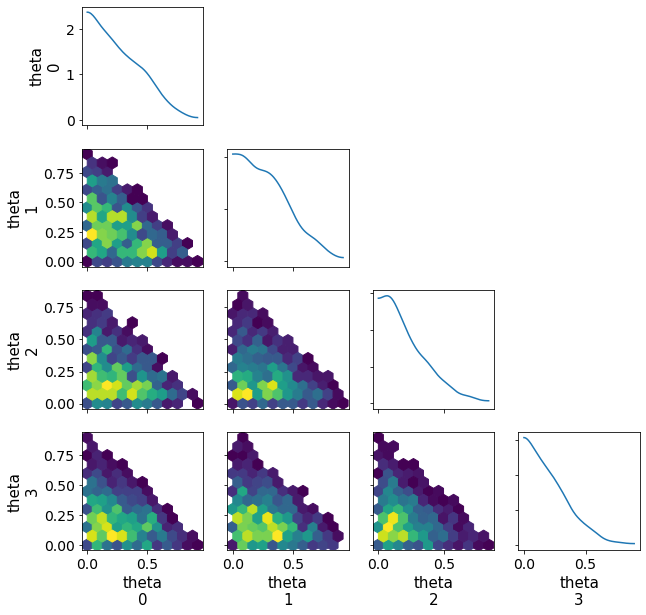

In [414]:
import arviz as az

data = az.from_pyro(py_mcmc)

az.plot_pair(
    data,
    var_names=["theta"],
#     coords={"school": ["Choate", "Phillips Andover"]},
    kind="hexbin",
    marginals=True,
    figsize=(10, 10),
)

now let's make it run for multiple Participants

In [478]:
def sim_sampling(p, beta, N):
    return dist.Beta(beta + p*N, beta + (1-p)*N).sample()

simulated_ps = 10

trials = list(df["querytype"])*simulated_ps

sim_probs = dm_probs(trials, t.tensor([.5,.1,.2,.2]), len(trials))
sim_obs = sim_sampling(sim_probs, 1., 50.)

test_data = {"trials":trials, 
             "obs":sim_obs, 
             "num_Ps":simulated_ps, 
             "obs_per_participant":20} # conjdisj_trials: ...,  conjdisj_obs: ...

## the model


In [479]:
bsampler_multi(test_data)

tensor([0.5581, 0.5136, 0.0852, 0.7060, 0.4000, 0.8006, 0.7862, 0.6118, 0.8224,
        0.5471, 0.3778, 0.1753, 0.1204, 0.3071, 0.6638, 0.4883, 0.3082, 0.3092,
        0.1707, 0.4575, 0.6603, 0.5526, 0.0992, 0.5807, 0.3732, 0.7383, 0.7597,
        0.6599, 0.8054, 0.3944, 0.3150, 0.2211, 0.1553, 0.2253, 0.7462, 0.5305,
        0.3998, 0.4318, 0.2782, 0.4685, 0.6625, 0.5522, 0.0820, 0.6765, 0.3595,
        0.7622, 0.8188, 0.7205, 0.8957, 0.5592, 0.4592, 0.3194, 0.2068, 0.2873,
        0.6791, 0.4065, 0.2037, 0.3169, 0.2499, 0.4840, 0.6016, 0.5106, 0.1323,
        0.6473, 0.3475, 0.8449, 0.6370, 0.7254, 0.8586, 0.4082, 0.3505, 0.1874,
        0.1897, 0.3323, 0.6325, 0.5108, 0.3929, 0.3515, 0.1316, 0.5302, 0.4904,
        0.4504, 0.0643, 0.7652, 0.3984, 0.7342, 0.8240, 0.7369, 0.8130, 0.5276,
        0.3047, 0.2631, 0.2430, 0.3285, 0.6198, 0.5272, 0.3137, 0.4211, 0.2153,
        0.5494, 0.6041, 0.6228, 0.0846, 0.7324, 0.3574, 0.8088, 0.7335, 0.7103,
        0.7943, 0.4206, 0.4489, 0.2168, 

In [481]:
from pyro.infer.mcmc import NUTS, MCMC

pyro.clear_param_store()
# conditioned_model = pyro.condition(bsampler, data={"y_hat":observations[0]})

nuts_kernel = NUTS(bsampler_multi, adapt_step_size=True)
py_mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=250)

py_mcmc.run(test_data)

Sample: 100%|██████████| 750/750 [1:17:45,  6.22s/it, step size=4.81e-04, acc. prob=0.812]


In [483]:
py_mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      1.46      0.19      1.46      1.20      1.75     10.46      1.00
         N      4.81      0.41      4.78      4.14      5.42      7.96      1.18
theta[0,0]      0.33      0.10      0.33      0.17      0.46     12.38      1.17
theta[0,1]      0.08      0.04      0.07      0.02      0.13     12.76      1.04
theta[0,2]      0.21      0.07      0.21      0.11      0.32      3.53      1.76
theta[0,3]      0.38      0.07      0.37      0.29      0.54     16.73      1.00
theta[1,0]      0.38      0.17      0.41      0.16      0.63      4.79      1.68
theta[1,1]      0.36      0.19      0.34      0.12      0.71      6.71      1.30
theta[1,2]      0.11      0.06      0.10      0.03      0.20     14.40      1.12
theta[1,3]      0.15      0.08      0.14      0.04      0.24      8.21      1.26
theta[2,0]      0.38      0.20      0.46      0.08      0.62      2.77      2.37
theta[2,1]      0.12      0

Well these dimensions came out all wrong/not as I was expectng. I suspect there's something about the first case I didn't understand

In [769]:
# need to change things around, feed in data separately for each trial type maybe?
def sort_trials(trial_data, observations):
    output = dict()
    for key in set(trial_data):
        output[key] = t.ones(0)
        
    for i in range(0, len(trial_data)):
        output[trial_data[i]] = t.cat( (output[trial_data[i]], t.tensor([observations[i]])) )
        
    return output

# simulated_blocks = 1

# trials = list(df["querytype"])*simulated_blocks

simulated_blocks = 100
trials = list(df["querytype"])*simulated_blocks

sim_probs = dm_probs(trials, t.tensor([.5,.1,.2,.2]), len(trials))
sim_obs = their_sim_sampling(sim_probs, 1., 10., 100.)

test_data = sort_trials(trials, sim_obs)
# test_data = {"data": sort_trials(trials, observations),
#              "num_Ps":simulated_ps, 
#              "obs_per_participant":20} # conjdisj_trials: ...,  conjdisj_obs: ...

## ok it's just slow!

def bsampler_multi(data):
#     n_total_obs = len(data["trials"])
    n_obs = len(data["A"])
    n_total_obs = len(data.keys())*n_obs

    # population level parameters/priors
    beta = pyro.sample("beta", dist.HalfCauchy(.25))
    N = pyro.sample("N", dist.HalfCauchy(5))
    k = pyro.sample("k", dist.HalfCauchy(5))

    # need a theta per person/querytype (yes?)    
    theta = pyro.sample("theta", dist.Dirichlet(t.ones(1, 4)))

    for trial in data.keys():
        f = t.vmap(trial_func[trial])
        pi = f(theta)
        p_bs = pi * N / (N + 2.*beta) + beta/(N + 2.*beta)   
        pyro.sample("yhat_{}".format(trial), dist.Beta(p_bs*k,(1.-p_bs)*k), obs=data[trial])
    
    return None


In [770]:
from pyro.infer.mcmc import NUTS, MCMC

pyro.clear_param_store()
# conditioned_model = pyro.condition(bsampler, data={"y_hat":observations[0]})

nuts_kernel = NUTS(bsampler_multi, adapt_step_size=True)
py_mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=250)

py_mcmc.run(test_data)

Sample: 100%|██████████| 750/750 [12:53,  1.03s/it, step size=3.98e-02, acc. prob=0.941]


In [771]:
py_mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      0.56      0.83      0.34      0.03      1.05    141.01      1.00
         N      5.56      8.18      3.42      0.28     10.34    140.93      1.00
         k     96.76      3.04     96.80     91.82    101.71    406.42      1.00
theta[0,0]      0.50      0.00      0.50      0.49      0.50    340.54      1.00
theta[0,1]      0.10      0.00      0.10      0.10      0.10    354.96      1.00
theta[0,2]      0.20      0.00      0.20      0.20      0.20    496.15      1.00
theta[0,3]      0.20      0.00      0.20      0.20      0.20    384.32      1.00

Number of divergences: 0


Hey Hey! Is that actually recovering the latent probabilities??? Seems like it did even with just one block. __That's HUGE.__ Seems to be running in same time with 10x observations, bumping it up to 100x starts to slow things down but not terribly

## multiple participants

ok now I appear to have things working for a single participant with multiple observations per trial. It's time to expand this to multiple paricipants.

In [917]:
## try to create new trial_funcs that can take a matrix theta

def test_func(theta):
    return t.matmul(theta, t.tensor([1.,0.,0.,0.])) 


trial_funcs = dict({
    "AandB": lambda theta: t.matmul(theta, t.tensor([1.,0.,0.,0.])) ,
    "AandnotB": lambda theta: t.matmul(theta, t.tensor([0.,1.,0.,0.])),
    "notAandB": lambda theta: t.matmul(theta, t.tensor([0.,0.,1.,0.])),
    "notAandnotB": lambda theta: t.matmul(theta, t.tensor([0.,0.,0.,1.])),
    "A":lambda theta: t.matmul(theta, t.tensor([1.,1.,0.,0.])),
    "B":lambda theta: t.matmul(theta, t.tensor([1.,0.,1.,0.])),
    "notA":lambda theta: t.matmul(theta, t.tensor([0.,0.,1.,1.])),
    "notB":lambda theta: t.matmul(theta, t.tensor([0.,1.,0.,1.])),
    "AorB":lambda theta: t.matmul(theta, t.tensor([1.,1.,1.,0.])),
    "AornotB":lambda theta: t.matmul(theta, t.tensor([1.,1.,0.,1.])),
    "notAorB":lambda theta: t.matmul(theta, t.tensor([0.,1.,1.,1.])),
    "notAornotB":lambda theta: t.matmul(theta, t.tensor([0.,1.,0.,1.])),
    
    "AgB": lambda theta: t.div( t.matmul(theta, t.tensor([1.,0.,0.,0.])), t.matmul(theta, t.tensor([1.,0.,1.,0.])) ),
    "notAgB": lambda theta: t.div( t.matmul(theta, t.tensor([0.,0.,1.,0.])), t.matmul(theta, t.tensor([1.,0.,1.,0.])) ),
    "AgnotB": lambda theta: t.div( t.matmul(theta, t.tensor([0.,1.,0.,0.])), t.matmul(theta, t.tensor([0.,1.,0.,1.])) ),
    "notAgnotB": lambda theta: t.div( t.matmul(theta, t.tensor([0.,0.,0.,1.])), t.matmul(theta, t.tensor([0.,1.,0.,1.])) ),
    "BgA": lambda theta: t.div( t.matmul(theta, t.tensor([1.,0.,0.,0.])), t.matmul(theta, t.tensor([1.,1.,0.,0.])) ),
    "notBgA": lambda theta: t.div( t.matmul(theta, t.tensor([0.,1.,0.,0.])), t.matmul(theta, t.tensor([1.,1.,0.,0.])) ),
    "BgnotA": lambda theta: t.div( t.matmul(theta, t.tensor([0.,0.,1.,0.])), t.matmul(theta, t.tensor([0.,0.,1.,1.])) ),
    "notBgnotA": lambda theta: t.div( t.matmul(theta, t.tensor([0.,0.,0.,1.])), t.matmul(theta, t.tensor([0.,0.,1.,1.])) )
})

for _ in trial_funcs.keys():
    print(trial_funcs[_](t.tensor(dist.Dirichlet(t.ones(6,4)).sample())))
    


tensor([0.0021, 0.3082, 0.1204, 0.1292, 0.0043, 0.3411])
tensor([0.0156, 0.3851, 0.0279, 0.2949, 0.1712, 0.4460])
tensor([0.3994, 0.0159, 0.1303, 0.2227, 0.1206, 0.0290])
tensor([0.3227, 0.2869, 0.2595, 0.0387, 0.0790, 0.4252])
tensor([0.4004, 0.7786, 0.3039, 0.3191, 0.5683, 0.1031])
tensor([0.5426, 0.5793, 0.7708, 0.5543, 0.4908, 0.6906])
tensor([0.7344, 0.0185, 0.7809, 0.7132, 0.5193, 0.5608])
tensor([0.3375, 0.5924, 0.4780, 0.4689, 0.0568, 0.3586])
tensor([0.5154, 0.9912, 0.8633, 0.6175, 0.5445, 0.7377])
tensor([0.9575, 0.9342, 0.9967, 0.6822, 0.5351, 0.8479])
tensor([0.8587, 0.5916, 0.2511, 0.7100, 0.8997, 0.5333])
tensor([0.2282, 0.8087, 0.9418, 0.1624, 0.9335, 0.6815])
tensor([0.1048, 0.0584, 0.4927, 0.4620, 0.3753, 0.6838])
tensor([0.3395, 0.9579, 0.6020, 0.4985, 0.9392, 0.9763])
tensor([0.5969, 0.7046, 0.4474, 0.0429, 0.2090, 0.3095])
tensor([0.3724, 0.4942, 0.3132, 0.6778, 0.1853, 0.4928])
tensor([0.0235, 0.7143, 0.7695, 0.4239, 0.4945, 0.3566])
tensor([0.2535, 0.8000, 0.0215,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [1129]:
simulated_blocks = 2
simulated_Ps = 3
trials = list(df["querytype"])*simulated_blocks*simulated_Ps

sim_obs = t.ones(0)

rng = np.random.default_rng()
# latent_probs = [rng.dirichlet(np.ones([4])) for _ in range(0, simulated_Ps)]
latent_probs = t.tensor([[.5,.1,.2,.2], [.2,.5,.1,.2], [.7, .1, .1, .1]])

for i in range(0, simulated_Ps):
    temp = list(df["querytype"])*simulated_blocks
#     sim_probs = dm_probs(temp, t.tensor([.5,.1,.2,.2]), len(temp))
    sim_probs = dm_probs(temp, t.tensor(latent_probs[i]), len(temp))
    sim_obs = t.cat( (sim_obs ,their_sim_sampling(sim_probs, 1., 10., 100.)) )
    
test_data = sort_trials(trials, sim_obs)
test_info = {"n_Ps":simulated_Ps, "n_blocks":simulated_blocks}

def bsampler_multi2(data, info):

    n_obs = len(data["A"])
    n_total_obs = len(data.keys())*n_obs
    n_Ps = info["n_Ps"]
    n_blocks = info["n_blocks"]

    # population level parameters/priors
    beta = pyro.sample("beta", dist.HalfCauchy(.25))
    N = pyro.sample("N", dist.HalfCauchy(5))
    k = pyro.sample("k", dist.HalfCauchy(5)) ## noise, all causes

    # need a theta per person/querytype (yes?)    

    thetas = [pyro.sample("theta_{}".format(j), dist.Dirichlet(t.ones(4))) for j in range(0,n_Ps)]
    theta = t.stack(thetas) # this works, not 100% sure if it's necessary vs just creating a n x 4 dirichlet

    for trial in data.keys():
        f = trial_funcs[trial]
        pi = f(theta).repeat_interleave(n_blocks) # changed from repeat() -- this fixed it!
        p_bs = pi * N / (N + 2.*beta) + beta/(N + 2.*beta) 
        
        yhat = pyro.sample("yhat_{}".format(trial), dist.Beta(p_bs*k, (1.-p_bs)*k), obs=data[trial]) # ???
    
    return pi

bsampler_multi2(test_data, test_info)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


tensor([0.2828, 0.2828, 0.7466, 0.7466, 0.4538, 0.4538])

In [1130]:
from pyro.infer.mcmc import NUTS, MCMC

pyro.clear_param_store()
# conditioned_model = pyro.condition(bsampler, data={"y_hat":observations[0]})

nuts_kernel = NUTS(bsampler_multi2, adapt_step_size=True)
py_mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=250)

py_mcmc.run(test_data, test_info)
# py_mcmc.summary()

Sample: 100%|██████████| 750/750 [09:00,  1.39it/s, step size=6.11e-02, acc. prob=0.950]


In [1131]:
py_mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      0.68      0.99      0.39      0.02      1.52    274.76      1.00
         N      5.42      8.19      3.28      0.14     12.23    287.81      1.00
         k    140.16     17.61    139.19    108.37    165.23    600.16      1.00
theta_0[0]      0.50      0.02      0.50      0.47      0.52    507.65      1.00
theta_0[1]      0.09      0.01      0.09      0.08      0.10    736.12      1.00
theta_0[2]      0.21      0.01      0.21      0.20      0.23    729.05      1.00
theta_0[3]      0.20      0.01      0.20      0.18      0.21    801.18      1.00
theta_1[0]      0.20      0.01      0.20      0.18      0.21    479.13      1.00
theta_1[1]      0.51      0.02      0.51      0.49      0.54    511.70      1.00
theta_1[2]      0.10      0.01      0.10      0.09      0.11    577.51      1.00
theta_1[3]      0.18      0.01      0.18      0.17      0.20    757.53      1.00
theta_2[0]      0.70      0

2021-03-18 - interestingly this does work for multiple participants each with one block. So it's some confusion of the dimensions most likely that is causing my problems with multiple blocks.

<AxesSubplot:ylabel='Count'>

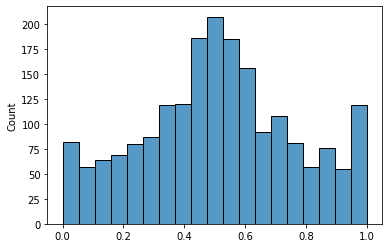

In [577]:
# maybe I should make this more functional/composed -- doesn't seem to be helping, making it worse possibly

def mental_model(query, theta):
    # query is a tensor for the matmul.
    # can I make this more flexible/truly vectorizable?
    p = t.matmul(theta, query)    
    return p

def bsampler(p, beta, N):
    
    pi = pyro.sample("pi", dist.Beta(p*N, p*N)) # generate samples (could be in mental model)
#     successes = pyro.sample("successes", dist.Binomial(p)) # this is what you actually want but it would add a discrete latent
#     failures = N - successes
    
    successes = pi*N
    failures = (1-pi)*N

    # this is where we diverge: they say it's the expectation that is returned, not a sample from the distribution.
    # that's a pretty substantive disagreement. 
    y_hat = pyro.sample("y_hat", dist.Beta(beta + successes, beta + failures)) 
    
    return y_hat

def model(query):
    theta = pyro.sample("theta", dist.Dirichlet(t.ones(4)))
    
    beta = pyro.sample("beta", dist.HalfCauchy(1))
    N = pyro.sample("N", dist.HalfCauchy(5))
    
    pi = mental_model(query, theta)
    
    return bsampler(pi, beta, N)


sns.histplot(np.array([model(t.tensor([1.,0.,0.,0.])) for _ in range(2000)]))

In [ ]:
# ok just to prove to myself that the mental model is affecting theta, it is!

def mental_model(query=None):
    
    # query is a tensor for the matmul.
    # can I make this more flexible/truly vectorizable?
    theta = pyro.sample("theta", dist.Dirichlet(t.ones(4)))
    
    query1 = t.tensor([1.,1.,0.,0.])
    p1 = t.matmul(theta, query1)
    pyro.sample("Z1", dist.Normal(p1, .01), obs=t.tensor(.8))
    
    query2 = t.tensor([0.,0.,1.,1.])
    p2 = t.matmul(theta, query2)
    pyro.sample("Z2", dist.Normal(p2, .01), obs=t.tensor(.1))
    
    return theta

IM = pyro.infer.Importance(mental_model, num_samples=3_000)
marginal = EmpiricalMarginal(IM.run())



/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

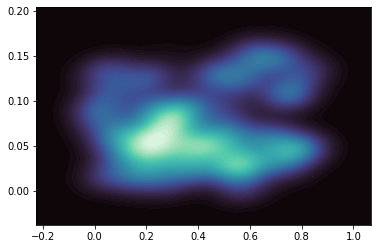

In [562]:
x = [marginal.sample() for _ in range(1000)]
sns.kdeplot(np.array([i[0] for i in x]), np.array([i[2] for i in x]),fill=True, thresh=0, levels=100, cmap="mako")

In [939]:
## old verisons

# this works for one P
# def bsampler_multi2(data, info):

#     n_obs = len(data["A"])
#     n_total_obs = len(data.keys())*n_obs
#     n_Ps = info["n_Ps"]
#     n_blocks = info["n_blocks"]

#     # population level parameters/priors
#     beta = pyro.sample("beta", dist.HalfCauchy(.25))
#     N = pyro.sample("N", dist.HalfCauchy(5))
#     k = pyro.sample("k", dist.HalfCauchy(5)) ## noise, all causes

#     # need a theta per person/querytype (yes?)    

# #     thetas = [pyro.sample("theta_{}".format(j), dist.Dirichlet(t.ones(4))) for j in range(0,n_Ps)]
# #     theta = t.stack(thetas) #     # this also didn't work

#     theta = pyro.sample("theta", dist.Dirichlet(t.ones(n_blocks, 4))) # change this to n_blocks

#     for trial in data.keys():
#         # ok so this is broken, result is the wrong size 
# #         f = t.vmap(trial_func[trial]) # maybe this isn't working?
#         f = trial_funcs[trial]
#         pi = f(theta) # now this is the wrong dim, should be n_blocks
#         p_bs = pi * N / (N + 2.*beta) + beta/(N + 2.*beta) # this is the wrong dim 
        
#         yhat = pyro.sample("yhat_{}".format(trial), dist.Beta(p_bs*k, (1.-p_bs)*k), obs=data[trial]) # ???
# #         yhat = pyro.sample("yhat_{}".format(trial), dist.Beta(p_bs*k, (1.-p_bs)*k)) # ???
    
#     return pi

# def bsampler_multi2(data, info):

#     n_obs = len(data["A"])
#     n_total_obs = len(data.keys())*n_obs
#     n_Ps = info["n_Ps"]
#     n_blocks = info["n_blocks"]

#     # population level parameters/priors
#     beta = pyro.sample("beta", dist.HalfCauchy(.25))
#     N = pyro.sample("N", dist.HalfCauchy(5))
#     k = pyro.sample("k", dist.HalfCauchy(5)) ## noise, all causes

#     # need a theta per person/querytype (yes?)    

# #     thetas = [pyro.sample("theta_{}".format(j), dist.Dirichlet(t.ones(4))) for j in range(0,n_Ps)]
# #     theta = t.stack(thetas) #     # this also didn't work

#     theta = pyro.sample("theta", dist.Dirichlet(t.ones(n_Ps, 4))) # change this to n_blocks

#     for trial in data.keys():
#         # ok so this is broken, result is the wrong size 
#         f = t.vmap(trial_func[trial]) # maybe this isn't working?
# #         f = trial_funcs[trial]
#         pi = f(theta) # now this is the wrong dim, should be n_blocks
#         p_bs = pi.repeat(n_blocks) * N / (N + 2.*beta) + beta/(N + 2.*beta) # this is the wrong dim 
        
#         yhat = pyro.sample("yhat_{}".format(trial), dist.Beta(p_bs*k, (1.-p_bs)*k), obs=data[trial]) # ???
# #         yhat = pyro.sample("yhat_{}".format(trial), dist.Beta(p_bs*k, (1.-p_bs)*k)) # ???
    
#     return yhat


def bsampler_multi2(data, info):

    n_obs = len(data["A"])
    n_total_obs = len(data.keys())*n_obs
    n_Ps = info["n_Ps"]
    n_blocks = info["n_blocks"]

    # population level parameters/priors
    beta = pyro.sample("beta", dist.HalfCauchy(.25))
    N = pyro.sample("N", dist.HalfCauchy(5))
    k = pyro.sample("k", dist.HalfCauchy(5)) ## noise, all causes
    
    # fuck it write it as a for-loop
    for trial in data.keys():
        f = trial_funcs[trial]
        for subj in range(0,n_Ps):
            theta = pyro.sample("theta_{}".format(subj), dist.Dirichlet(t.ones(4)))
            pi = f(theta).repeat(n_blocks)
            p_bs = pi * N / (N + 2.*beta) + beta/(N + 2.*beta) # this is the wrong dim 
        
            yhat = pyro.sample("yhat_{}".format(trial), dist.Beta(p_bs*k, (1.-p_bs)*k), obs=data[trial])
    
    return yhat

bsampler_multi2(test_data, test_info)

tensor([0.2776, 0.2118, 0.3872, 0.3186, 0.2376, 0.3574, 0.3289, 0.4007, 0.3160,
        0.3582])